# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Project Approach

## Problem Statement

For this project a model will be built that predicts whether a customer will view and complete an offer based on the customer information and the offer characteristics. This prediction can then be used to identify the best offer to a customer based on how likely it is that the customer will be influenced by the offer. 
Any offer can fall into one of four categories on the viewed/completion matrix: 

|----------|Completed|Not Completed|
|----------|---------|-------------|
|Viewed|1|2|
|Not Viewed|4|3|

The value of each category can be ranked from most desirable (1) to least desirable (4). Based on this a simple recommendation function can be built that uses the insights gained from the models predictions. 


## Project Design

In a first step the datasets will be cleaned. This means dropping any customer profiles that are incomplete and the transactions recorded from these incomplete customer profiles. Next the transaction volume per customer per week will be added as additional information to the customer profiles. Lastly, a dataset that records all the offers sent to customers and their outcomes (i.e. whether they were viewed and whether they were completed) will be constructed. For every offer sent the personal information of the customer will be added to the offer dataset to construct the input dataset explained above. 
After the dataset has been split into test and training set, the Benchmark model will be trained to establish the Benchmark. 
Next several different Machine Learning models will be trained and tested to see which model performs best based on the evaluation metrics. 
Lastly, once the best model has been picked, a sample recommendation function will be introduced. This recommendation sample will take the customer ID as input and then predict the outcomes for the available offers for this customers. Once the outcomes are known a predetermined ranking will identify which offer is most suitable for the customer and this offer will be returned.
To achieve this the project has been split into the following sections:
0. Data Exploration
1. Data Pre-Processing
2. Data Exploration 2.0
3. Creation of Training & Testing Sets
4. Benchmark Model
5. Machine Learning Models
6. Sample Recommendation Function


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import os
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 0. Data Exploration
Before jumping into the project, it makes sense to take a quick look at the available datasets to get a better feel for the data. In the following the form of the datasets and whether or not the datasets are complete. As these datasets will be changed significantly before using them for the model, a more detailed data exploration section will follow after the Data Pre-Processing.


In [3]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
# Shape of datasets
print('Shape of Profile Dataset: {}'.format(profile.shape))
print('Shape of Transcript Dataset: {}'.format(transcript.shape))

Shape of Profile Dataset: (17000, 5)
Shape of Transcript Dataset: (306534, 4)


In [7]:
#Missing Values
print('Missing values in Profile Dataset: {}'.format(profile.isnull().sum().sum()))
print('Missing values in Transcript Dataset: {}'.format(transcript.isnull().sum().sum()))

Missing values in Profile Dataset: 4350
Missing values in Transcript Dataset: 0


For later use, a simple transformation of the portfolio dataframe will be made here: The list of channels will be split into for diiferent binary columns, i.e., channel_web, channel_social, channel_email and channel_mobile

In [19]:
#define a function to map the channels to a binary column
def transform_channels(row, name):
    #fill column with 1 if channel is included in list of channels, else 0
    return_value = 0
    for channel in row['channels']:
        if channel == name:
            return_value = 1
            break
    return return_value

#apply function to the portfolio dataframe
portfolio['channel_web'] = portfolio.apply(lambda row: transform_channels(row, 'web'), axis=1)
portfolio['channel_email'] = portfolio.apply(lambda row: transform_channels(row, 'email'), axis=1)
portfolio['channel_mobile'] = portfolio.apply(lambda row: transform_channels(row, 'mobile'), axis=1)
portfolio['channel_social'] = portfolio.apply(lambda row: transform_channels(row, 'social'), axis=1)

#drop original channels column
portfolio.drop('channels', axis = 1, inplace = True)

In [20]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,channel_web,channel_email,channel_mobile,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


# 1. Data Pre-Processing
The goal of the data pre-processing is to obtain a Dataset that can be used to train a supervised learning model. The resulting dataset should consist of a label (i.e., which category in the viewed/completed matrix the observation falls into) and a number of input variables including the available information about a customer, the offer type and the average weekly transaction volumes of a customer. 

To achieve this goal a number of steps have to be taken: 
1. Data Cleaning
2. Construction of Source Datasets from the available Data
3. Feature Transformation and Scaling

## 1.1 Data Cleaning

The first step in Data Pre-Processing is the data cleaning step. For the available datasets this is limited to dropping any incomplete cells. Only the profile dataframe has observations with incomplete data. However, as the transcript dataframe also records transactions of customers that have an incomplete profile, the transcript dataframe, all entries in the transcript dataframe that relate to an incomplete customer profile have to be dropped.



In [21]:
def data_cleaning(profile_df, transcript_df):
    ''' Function for dropping all incomplete entries from the profile dataframe and also deleting the 
    corresponding entries of the transcript dataframe
    Parameters: 
                profile_df - pandas.DataFrame holding customer data
                transcript_df - pandas.DataFrame holding transaction data
    Output: 
                clean_profile_df - profile_df excluding all rows that have NA vlaues
                clean_transcript_df - transcript_df excluding all rows refering to a dropped row from profile_df
    '''
    #store current number of entries in transcript_df and profile_df for later use
    num_rows_t = transcript_df.shape[0]
    num_rows_p = profile_df.shape[0]
    
    # get a dataframe with all observations in profile_df that have missing values
    incomplete = profile_df[profile_df.isnull().any(axis = 1)]
    # for every entry in the incomplete dataframe, drop all correspronding entries from the transcript_df 
    for index, row in incomplete.iterrows():
        #store person_id as string
        ident = str(row['id'])
        # create dataframe where all entries that have the incomplete id are dropped
        transcript_df = transcript_df.loc[transcript_df['person'] != ident]
        
    # drop all incomplete rows from profile_df now that the transcript is cleaned 
    profile_df.dropna(axis = 0, inplace = True)
    
    # show how many lines were dropped in total
    print('{} Entries were dropped from transcript'.format(num_rows_t - transcript_df.shape[0])) 
    print('{} Entries were dropped from profile'.format(num_rows_p - profile_df.shape[0]))
    
    #return cleaned version of profile_df and transcript_df
    return profile_df, transcript_df
    

In [22]:
#Test the cleaning function
profile_test = profile.head(100)
transcript_test = transcript.copy()

%time clean_profile, clean_transcript = data_cleaning(profile_test, transcript_test)

333 Entries were dropped from transcript
21 Entries were dropped from profile
CPU times: user 999 ms, sys: 11.5 ms, total: 1.01 s
Wall time: 1.01 s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
profile_test = None
transcript_test = None

In [24]:
# Excecute the cleaning function and store the cleaned datasets
clean_profile, clean_transcript = data_cleaning(profile.copy(), transcript.copy())

33772 Entries were dropped from transcript
2175 Entries were dropped from profile


In [25]:
clean_profile.shape

(14825, 5)

## 1.2 Construction of Input Datasets from the available Data

Now that the datasets only contain complete datapoints, the next step is to turn the datasets into a single dataframe that can be used to train a model. Once again the input dataset should consist of information about the customer and the offer type. The label is the category of the viewed/completed matrix the particular offer falls into. The customer information is made up of the information in the clean_profile dataframe as well as information about the transaction volume of the customer. The offer data comes from the portfolio dataframe. Most importantly, each offer that was received has to be filtered out of the transcript dataframe and put into a new dataframe where it can be sorted to show which offer was viewed and completed. 

The first step will be to sort through the clean_transcript dataframe and create a new offer_df dataframe that holds every offer that was sent to customers and whether this offer was viewed and completed. The dataframe thus requires four columns: a customer id, the offer id, a binary variable 'viewed' with 0 for not viewed and 1 for viewed and a binary variable 'completed' with 0 for not completed and 1 for completed. 
At a later stage this dataframe can then be extended with the additional information. An offer only counts as viewed if it was viewed before it was completed.

To obtain this dataset two functions will be used. The first function __create_customer_offers__ will generate a dataframe with the columns described above for one single customer and hold the information for all the offers this customer received. The second function __create_offer_overview__ will then iterate over every customer and call the __create_customer_offers__ to built a dataframe that holds all the offers recorded in the clean_transcript dataframe.

In [59]:
def create_customer_offers(received_df, viewed_df, completed_df, portfolio):
    ''' Function for creating a new dataframe that records all the offers that were sent to a single customer and
    record whether the offer was viewed and completed.
    Parameters:
                received_df - pandas.DataFrame holding the records for all received offers
                viewed_df - pandas.DataFrame holding the records for all viewed offers
                completed_df - pandas.DataFrame holding the records for all completed offers
                portfolio - pandas.DataFrame holding the details about the different offer types
                
    Output: 
                customer_offers - pandas.DataFrame that holds infromation on each offer made to customers
    '''
    
    column_names = ['person', 'offer_id', 'viewed', 'completed']
    customer_offers = pd.DataFrame(columns = column_names)
    # make an entry
    for index, row in received_df.iterrows():
        #create a dictionary with the entries
        entry = {}
        #set all variables that might not be changed to None
        time_com = time_view = None
        
        #get person id of received offer
        entry['person'] = row['person']
        
        #get offer id and time of received offer
        offer_ident = row['value']['offer id']
        time_rec = int(row['time'])
        #calculate valid duration time in hours
        dur = portfolio.loc[portfolio['id'] == offer_ident]['duration'].squeeze() * 24
        #update in dictionary
        entry['offer_id'] = offer_ident
        #fill completed column with 0 if not completed and 1 if completed
        completed = 0
        for index, row in completed_df.iterrows():
            #store the time of completion
            time_com = int(row['time'])
            # if the received offer id appears in the completed section and the time difference is not bigger
            # than the offer duration, set completed to 1
            if str(row['value']['offer_id']) == str(offer_ident) and time_com - time_rec < dur:
                completed = 1
                break
        # update completed entry
        entry['completed'] = completed
        
        #fill viewed column with 0 if not viewed and 1 if viewed
        viewed = 0
        for index, row in viewed_df.iterrows():
            #store the time viewed
            time_view = int(row['time'])
            # if the received offer id appears in the viewed section and the view time is before the completion time
            # set viewed to 1
            if str(row['value']['offer id']) == str(offer_ident): 
                #if there is no completion time set viewed to 1
                if time_com == None:
                    viewed = 1
                    break
                #if there is a completion time, check if completion time is after view time
                elif time_view < time_com:
                    viewed = 1
                    break
        # update viewed entry
        entry['viewed'] = viewed
        
        #add entry to the dataframe
        customer_offers = customer_offers.append(entry, ignore_index=True)
        
        
    #return dataframe
    return customer_offers
        


In [60]:
def create_offer_overview(profile_df, transcript_df, portfolio):
    ''' Function for creating a new dataframe that records all the offers that were sent and whether they were
    viewed and completed. The function iterates over every customer and then calls the create_customer_offers 
    function to get the relevant DataFrame entries for the specific customer. It then adds these entries to 
    the offer_df DataFrame.
    Parameters:
                profile_df - pandas.DataFrame holding customer data
                transcript_df - pandas.DataFrame holding transaction data
                portfolio - pandas.DataFrame holding the details about the different offer types
    Output: 
                offer_df - pandas.DataFrame that holds infromation on each offer made to customers
    '''
    #Create the output Dataframe object:offer_df
    column_names = ['person', 'offer_id', 'viewed', 'completed']
    offer_df = pd.DataFrame(columns = column_names)
    
    #Iterate over every customer in the clean_profile dataframe and create the relevant datapoints
    
    for index, row in profile_df.iterrows():
        #create 3 dataframes with received, viewed and completed offers of the customer
        
        #store customer id
        cust_id = row['id']
        #filter out customers transactions from the transcript
        cust_transactions = transcript_df.loc[transcript_df['person'] == str(cust_id)]
        #split the customer transactions into 3 datasets for received, completed and viewed offers
        #received-df
        received_df = cust_transactions.loc[cust_transactions['event'] == 'offer received']
        #viewed-df
        viewed_df = cust_transactions.loc[cust_transactions['event'] == 'offer viewed']
        #completed-df
        completed_df = cust_transactions.loc[cust_transactions['event'] == 'offer completed']
        
        #call the create_customer_offers function to create the dataframe entries for the customer
        cust_entries = create_customer_offers(received_df, viewed_df, completed_df, portfolio)
        
        #append the customer entries to offer_df 
        offer_df = offer_df.append(cust_entries)
    
    
    return offer_df
    
    

In [61]:
#test function
test_profile = clean_profile.head(100)
test_transcript = clean_transcript.copy()

%time result = create_offer_overview(test_profile, test_transcript, portfolio)

result.head()

CPU times: user 5.08 s, sys: 0 ns, total: 5.08 s
Wall time: 5.08 s


,person,offer_id,viewed,completed
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1
1,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,0,0
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1


In [62]:
# Create the new offer_df dataset with the create_offer_overview function
offer_df = create_offer_overview(clean_profile, clean_transcript, portfolio)

Checkpoint: Save the offer_df file to csv in order to have acces to it when restarting the notebook

In [ ]:
#save offer_df file locally
offer_df.to_csv('data/Local Save Files/offer_df.csv')

In [19]:
#load offer_df file if necessary
offer_df = pd.read_csv('data/Local Save Files/offer_df.csv', index_col = 0)

The next step is to transform the viewed and completed column and add a label column that assigns the labels to the four categories of the viewed/completed matrix. The categories will be ordered from most to least desirable, i.e.:

0 = viewed & completed; 
1 = viewed & not completed; 
2 = not viewed & not completed; 
3 = not viewed & completed;

In [20]:
#define a function to map the values in the viewed & completed column to their labels
def mapping_func(row):
    #map values to categories
    if row['viewed'] == 1 and row['completed'] == 1:
        return 0
    if row['viewed'] == 1 and row['completed'] == 0:
        return 1
    if row['viewed'] == 0 and row['completed'] == 0:
        return 2
    if row['viewed'] == 0 and row['completed'] == 1:
        return 3
    #check if error
    return np.nan

#apply function to the offer_df dataframe
offer_df['label'] = offer_df.apply(lambda row: mapping_func(row), axis=1)

#Sanity Check
print('Missing values in labels column: {}'.format(offer_df.isnull().sum().sum()))
offer_df.head()

Missing values in labels column: 0


,person,offer_id,viewed,completed,label
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,3
1,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,0,0,2
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0


Now that the order_df dataframe is complete, the next step is to extend the dataframe to include the information about the offer. This can be done similarly to the mapping of the labels by taking the information from the portfolio dataframe and the offer_id in the offer_df dataframe. As a result a new dataframe dataframe __offer_df_extended__ will be created. __The features are not yet scaled!!__

In [21]:
# define function to add information from the portfolio dataframe based on the offer_id
def add_offer_info(row, portfolio, column):
    return portfolio.loc[portfolio['id'] == row['offer_id']][column].squeeze()

# add the relevant columns to the offer_df dataset in a new dataframe offer_df_extended
offer_df_extended = offer_df.copy()
# add channel_web
offer_df_extended['offer_channel_web'] = offer_df_extended.apply(lambda row: add_offer_info(row, portfolio, 'channel_web'), axis=1)
# add channel_email
offer_df_extended['offer_channel_email'] = offer_df_extended.apply(lambda row: add_offer_info(row, portfolio, 'channel_email'), axis=1)
# add channel_mobile
offer_df_extended['offer_channel_mobile'] = offer_df_extended.apply(lambda row: add_offer_info(row, portfolio, 'channel_mobile'), axis=1)
# add channel_social
offer_df_extended['offer_channel_social'] = offer_df_extended.apply(lambda row: add_offer_info(row, portfolio, 'channel_social'), axis=1)
# add type
offer_df_extended['offer_type'] = offer_df_extended.apply(lambda row: add_offer_info(row, portfolio, 'offer_type'), axis=1)
# add reward
offer_df_extended['offer_reward'] = offer_df_extended.apply(lambda row: add_offer_info(row, portfolio, 'reward'), axis=1)
#add difficulty
offer_df_extended['offer_difficulty'] = offer_df_extended.apply(lambda row: add_offer_info(row, portfolio, 'difficulty'), axis=1)
#add duration of offer
offer_df_extended['offer_duration'] = offer_df_extended.apply(lambda row: add_offer_info(row, portfolio, 'duration'), axis=1)

In [22]:
offer_df_extended.head()

,person,offer_id,viewed,completed,label,offer_channel_web,offer_channel_email,offer_channel_mobile,offer_channel_social,offer_type,offer_reward,offer_difficulty,offer_duration
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,3,1,1,1,0,bogo,5,5,7
1,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,0,0,2,1,1,1,0,informational,0,0,4
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,1,0,bogo,5,5,7
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,1,0,1,1,1,informational,0,0,3
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,0,1,1,1,bogo,10,10,7


Now that we have all the information about the offers in one dataframe, the customer information will be constructed and added. For this the transaction volume per customer per week will be added to the profile dataframe. This information will then later be added to the offer_df_extended dataframe.

In [26]:
#define a function that calculates the weekly transaction volume for one customer
def get_transaction_per_customer(transaction_df):
    ''' Function for creating a new dataframe that records the transaction volume of a customer per full week of the
    test period - transaction time is recorded in hours (max is 714h -> which makes 4.25 weeks)
    Parameters:
                transaction_df - pandas.DataFrame holding the records for all transactions of the customer
                
    Output: 
                weekly_spent - Dictionary that holds the transaction volume per week of a customer
    '''
    
    # initialize variables that count transaction volume
    spend_wk_1 = spend_wk_2 = spend_wk_3 = spend_wk_4 = 0
    #iterate over each row and add amount spent to the total in the correct week
    for index, row in transaction_df.iterrows():
        #if time is within first 7 days (i.e., 7 * 24h = 168)
        if row['time'] < 169:
            spend_wk_1 += row['value']['amount']
        #if time is within second 7 days (i.e., 168 + 7 * 24h = 336)
        elif row['time'] < 337:
            spend_wk_2 += row['value']['amount']
        #if time is within third 7 days (i.e., 336 + 7 * 24h = 504)
        elif row['time'] < 505:
            spend_wk_3 += row['value']['amount']
        #if time is within fourth 7 days (i.e., 504 + 7 * 24h = 672)
        elif row['time'] < 673:
            spend_wk_4 += row['value']['amount']
        #all transactions in the last (incomplete) week are ignored
    #create dictionary with the values for each week
    weekly_spent = {'spend_wk_1' : spend_wk_1,
                    'spend_wk_2' : spend_wk_2,
                    'spend_wk_3' : spend_wk_3,
                    'spend_wk_4' : spend_wk_4}
    
    #return dictionary
    return weekly_spent

In [27]:
def get_customer_spending(profile_df, transcript_df):
    ''' Function for creating a new dataframe that adds the weekly spending totals for each customer in the
    4 full weeks of the test phase to the information in the profile_df dataframe.
    Parameters:
                profile_df - pandas.DataFrame holding customer data
                transcript_df - pandas.DataFrame holding transaction data
    Output: 
                profile_extended_df - pandas.DataFrame that holds infromation on the weekly transaction volumes of customers,
                                    in addition to the information already known from the profile_df
    '''
    #Create the output Dataframe object:offer_df
    column_names = ['id','gender','age','became_member_on','income', 'spend_wk_1', 'spend_wk_2',
                    'spend_wk_3', 'spend_wk_4']
    profile_extended_df = pd.DataFrame(columns = column_names)
    
    #Iterate over every customer in the clean_profile dataframe and create the relevant datapoints
    
    for index, row in profile_df.iterrows():
        #create a dataframe with the transactions of a single customer
        #store customer id
        cust_id = row['id']
        #filter out customers transactions from the transcript
        cust_transactions = transcript_df.loc[transcript_df['person'] == str(cust_id)]
        #get a dataset with only the transactions
        transaction_df = cust_transactions.loc[cust_transactions['event'] == 'transaction']
        #fill the first columns of the new dataframe from the original profile dataframe
        entry = {'id': cust_id,
                'gender': row['gender'],
                 'age': row['age'],
                 'became_member_on': row['became_member_on'],
                 'income': row['income']}
        #get dictionary with weekly spent of customer from get_transaction_per_customer function
        weekly_spent = get_transaction_per_customer(transaction_df)
        #append spending info to entry dictionary
        entry.update(weekly_spent)
        
        #append entry to dataframe
        profile_extended_df = profile_extended_df.append(entry, ignore_index=True)
        
    #return dataframe
    return profile_extended_df

In [28]:
#test function
test_profile = clean_profile.head(100)
test_transcript = clean_transcript.copy()

%time result = get_customer_spending(test_profile, test_transcript)

result.head()

CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 2.53 s


,id,gender,age,became_member_on,income,spend_wk_1,spend_wk_2,spend_wk_3,spend_wk_4
0,0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0,53.79,0,0,23.22
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,37.67,49.39,23.93,48.28
2,e2127556f4f64592b11af22de27a7932,M,68,20180426,70000.0,0.00,39.31,0,18.42
3,389bc3fa690240e798340f5a15918d5c,M,65,20180209,53000.0,9.54,0,15.63,11.26
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,20171111,51000.0,0.00,2.32,12.43,0.87


In [29]:
# Create the new profile_extended_df dataframe with the get_customer_spending method
profile_extended_df = get_customer_spending(clean_profile, clean_transcript)

The Profile_extended_df now holds all infromation available about each customer. The next step is to add this information to the offer_extended_df to arrive at a dataset that includes all offer and personal information for each offer that was made in the test period. This will be the dataset (after it has been cleaned & transformed) that serves as a basis for the ML model. The became member on column will not be transferred as it is not likely to have an impact on the behavior of the cusomer

In [29]:
# define function to add the personal information based on the id of a customer
def add_cust_info(row, profile_extended_df, column):
    return profile_extended_df.loc[profile_extended_df['id'] == row['person']][column].squeeze()

# add the relevant columns to the offer_df dataset in a new dataframe offer_df_extended
full_offer_df = offer_df_extended.copy()
# add gender
full_offer_df['cust_gender'] = full_offer_df.apply(lambda row: add_cust_info(row, profile_extended_df, 'gender'), axis=1)
# add age
full_offer_df['cust_age'] = full_offer_df.apply(lambda row: add_cust_info(row, profile_extended_df, 'age'), axis=1)
#add income
full_offer_df['cust_income'] = full_offer_df.apply(lambda row: add_cust_info(row, profile_extended_df, 'income'), axis=1)
#spend_wk_1
full_offer_df['cust_spend_wk_1'] = full_offer_df.apply(lambda row: add_cust_info(row, profile_extended_df, 'spend_wk_1'), axis=1)
#spend_wk_2
full_offer_df['cust_spend_wk_2'] = full_offer_df.apply(lambda row: add_cust_info(row, profile_extended_df, 'spend_wk_2'), axis=1)
#spend_wk_3
full_offer_df['cust_spend_wk_3'] = full_offer_df.apply(lambda row: add_cust_info(row, profile_extended_df, 'spend_wk_3'), axis=1)
#spend_wk_4
full_offer_df['cust_spend_wk_4'] = full_offer_df.apply(lambda row: add_cust_info(row, profile_extended_df, 'spend_wk_4'), axis=1)

#show first 5 rows of complete dataset
full_offer_df.head()

,person,offer_id,viewed,completed,label,offer_channel_web,offer_channel_email,offer_channel_mobile,offer_channel_social,offer_type,offer_reward,offer_difficulty,offer_duration,cust_gender,cust_age,cust_income,cust_spend_wk_1,cust_spend_wk_2,cust_spend_wk_3,cust_spend_wk_4
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,3,1,1,1,0,bogo,5,5,7,F,55,112000.0,53.79,0.00,0.00,23.22
1,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,0,0,2,1,1,1,0,informational,0,0,4,F,55,112000.0,53.79,0.00,0.00,23.22
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,1,0,bogo,5,5,7,F,75,100000.0,37.67,49.39,23.93,48.28
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,1,0,1,1,1,informational,0,0,3,F,75,100000.0,37.67,49.39,23.93,48.28
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,0,1,1,1,bogo,10,10,7,F,75,100000.0,37.67,49.39,23.93,48.28


In [30]:
#rearrange order of columns (purely cosmetic)
column_names = ['person', 'offer_id', 'viewed', 'completed', 'label', 'offer_type', 'offer_reward', 'offer_difficulty', 'offer_duration', 'cust_gender', 'cust_age', 'cust_income', 'cust_spend_wk_1', 'cust_spend_wk_2', 'cust_spend_wk_3', 'cust_spend_wk_4',  'offer_channel_web', 'offer_channel_email', 'offer_channel_mobile', 'offer_channel_social']
full_offer_df = full_offer_df[column_names]

Checkpoint: Save full_offer_df dataframe to csv locally

In [31]:
#save full_offer_df file locally
full_offer_df.to_csv('data/Local Save Files/full_offer_df.csv')

In [32]:
#load full_offer_df file if necessary
full_offer_df = pd.read_csv('data/Local Save Files/full_offer_df.csv', index_col = 0)

## 1.3 Feature Transformation and Scaling

The dataframe full_offer_df now holds all information available about the offer and the customer as well as the outcome of the offer in the viewed/completed matrix. To make the dataframe useable in a machine learning algorithm, the features now have to be selected and then transformed and scaled. 

Each column has to be either dropped, transformed or scaled. All the columns that hold information that is either already contained in another column, or leads to a unique identification of an observation, have to be dropped. This includes the id columns, and the viewed and completed columns. 

In [33]:
#create transformed_offer_df with the id and duplicate columns dropped
transformed_offer_df = full_offer_df.drop(['person', 'offer_id', 'viewed', 'completed'], axis=1)
transformed_offer_df.head()

,label,offer_type,offer_reward,offer_difficulty,offer_duration,cust_gender,cust_age,cust_income,cust_spend_wk_1,cust_spend_wk_2,cust_spend_wk_3,cust_spend_wk_4,offer_channel_web,offer_channel_email,offer_channel_mobile,offer_channel_social
0,3,bogo,5,5,7,F,55,112000.0,53.79,0.00,0.00,23.22,1,1,1,0
1,2,informational,0,0,4,F,55,112000.0,53.79,0.00,0.00,23.22,1,1,1,0
0,0,bogo,5,5,7,F,75,100000.0,37.67,49.39,23.93,48.28,1,1,1,0
1,1,informational,0,0,3,F,75,100000.0,37.67,49.39,23.93,48.28,0,1,1,1
2,0,bogo,10,10,7,F,75,100000.0,37.67,49.39,23.93,48.28,0,1,1,1


The second category are columns that have to be transformed. This refers to all columns that hold categorical data. Each of these columns will be transformed using the pandas.get_dummies method to generate a dummy representation of these categorical columns. This includes the columns: offer_type, offer_reward, offer_difficulty, offer_duration and cust_gender. Note that the offer_channel_X columns are already binary and therefore do not have to be changed.

In [34]:
#get_dummies for all the categorical variables except offer_channels 
column_names = ['offer_type', 'offer_reward', 'offer_difficulty', 'offer_duration', 'cust_gender']
transformed_offer_df = pd.get_dummies(transformed_offer_df, columns = column_names)

transformed_offer_df.head()

,label,cust_age,cust_income,cust_spend_wk_1,cust_spend_wk_2,cust_spend_wk_3,cust_spend_wk_4,offer_channel_web,offer_channel_email,offer_channel_mobile,...,offer_difficulty_10,offer_difficulty_20,offer_duration_3,offer_duration_4,offer_duration_5,offer_duration_7,offer_duration_10,cust_gender_F,cust_gender_M,cust_gender_O
0,3,55,112000.0,53.79,0.00,0.00,23.22,1,1,1,...,0,0,0,0,0,1,0,1,0,0
1,2,55,112000.0,53.79,0.00,0.00,23.22,1,1,1,...,0,0,0,1,0,0,0,1,0,0
0,0,75,100000.0,37.67,49.39,23.93,48.28,1,1,1,...,0,0,0,0,0,1,0,1,0,0
1,1,75,100000.0,37.67,49.39,23.93,48.28,0,1,1,...,0,0,1,0,0,0,0,1,0,0
2,0,75,100000.0,37.67,49.39,23.93,48.28,0,1,1,...,1,0,0,0,0,1,0,1,0,0


The thrid and last step is to scale all the remaining columns, i.e., all non-categorical columns. This includes the columns income, age, and the weekly spending columns. To transform the columns scikit learns min-max scaler will be employed. 

In [35]:
#import minMax Scaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler
#create scaler instance
scaler = MinMaxScaler()
#specify columns that have to be scaled by MinMaxScaler
column_names = ['cust_age','cust_income', 'cust_spend_wk_1', 'cust_spend_wk_2', 'cust_spend_wk_3', 'cust_spend_wk_4']
#fit_transform all non-categorical columns of the dataframe
transformed_offer_df[column_names] = scaler.fit_transform(transformed_offer_df[column_names].astype(np.float64))

#show transformed dataframe
transformed_offer_df.head()


,label,cust_age,cust_income,cust_spend_wk_1,cust_spend_wk_2,cust_spend_wk_3,cust_spend_wk_4,offer_channel_web,offer_channel_email,offer_channel_mobile,...,offer_difficulty_10,offer_difficulty_20,offer_duration_3,offer_duration_4,offer_duration_5,offer_duration_7,offer_duration_10,cust_gender_F,cust_gender_M,cust_gender_O
0,3,0.445783,0.911111,0.051596,0.000000,0.000000,0.021795,1,1,1,...,0,0,0,0,0,1,0,1,0,0
1,2,0.445783,0.911111,0.051596,0.000000,0.000000,0.021795,1,1,1,...,0,0,0,1,0,0,0,1,0,0
0,0,0.686747,0.777778,0.036134,0.043447,0.022815,0.045318,1,1,1,...,0,0,0,0,0,1,0,1,0,0
1,1,0.686747,0.777778,0.036134,0.043447,0.022815,0.045318,0,1,1,...,0,0,1,0,0,0,0,1,0,0
2,0,0.686747,0.777778,0.036134,0.043447,0.022815,0.045318,0,1,1,...,1,0,0,0,0,1,0,1,0,0


Checkpoint: Save final dataset to csv locally, for reuse if kernel is stopped.

In [ ]:
#save transformed_offer_df file locally
transformed_offer_df.to_csv('data/Local Save Files/transformed_offer_df.csv')

In [2]:
#load transformed_offer_df file if necessary
transformed_offer_df = pd.read_csv('data/Local Save Files/transformed_offer_df.csv', index_col = 0)

Based on the information in the transformed_offer_df the models are likely to identify the exact offer sent to each customer and therefore just pick the most likely offer for each customer and always return this. Therfore, an alternative dataframe with less offer information will be constructed here to test whether the models behave differently, i.e., better. Also the difficulty, duration and reward variables will be treated as numerical not categorical variables.

In [104]:
#create alt_offer_df with the id and duplicate columns dropped
#also drop the columns offer_difficulty and offer_reward and the offer_channels to prevent offers being 
#uniquely identifieable
alt_offer_df = full_offer_df.drop(['person', 'offer_id', 'viewed', 'completed','offer_reward', 'offer_difficulty',
                                  'offer_channel_web', 'offer_channel_email', 'offer_channel_mobile', 
                                   'offer_channel_social'], axis=1)
alt_offer_df.head()

,label,offer_type,offer_duration,cust_gender,cust_age,cust_income,cust_spend_wk_1,cust_spend_wk_2,cust_spend_wk_3,cust_spend_wk_4
0,3,bogo,7,F,55,112000.0,53.79,0.00,0.00,23.22
1,2,informational,4,F,55,112000.0,53.79,0.00,0.00,23.22
0,0,bogo,7,F,75,100000.0,37.67,49.39,23.93,48.28
1,1,informational,3,F,75,100000.0,37.67,49.39,23.93,48.28
2,0,bogo,7,F,75,100000.0,37.67,49.39,23.93,48.28


In [105]:
#get_dummies for all the categorical variables except offer_channels 
column_names = ['offer_type', 'cust_gender']
alt_offer_df = pd.get_dummies(alt_offer_df, columns = column_names)

alt_offer_df.head()

,label,offer_duration,cust_age,cust_income,cust_spend_wk_1,cust_spend_wk_2,cust_spend_wk_3,cust_spend_wk_4,offer_type_bogo,offer_type_discount,offer_type_informational,cust_gender_F,cust_gender_M,cust_gender_O
0,3,7,55,112000.0,53.79,0.00,0.00,23.22,1,0,0,1,0,0
1,2,4,55,112000.0,53.79,0.00,0.00,23.22,0,0,1,1,0,0
0,0,7,75,100000.0,37.67,49.39,23.93,48.28,1,0,0,1,0,0
1,1,3,75,100000.0,37.67,49.39,23.93,48.28,0,0,1,1,0,0
2,0,7,75,100000.0,37.67,49.39,23.93,48.28,1,0,0,1,0,0


In [106]:
#import minMax Scaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler
#create scaler instance
scaler = MinMaxScaler()
#specify columns that have to be scaled by MinMaxScaler
column_names = ['cust_age','cust_income', 'cust_spend_wk_1', 'cust_spend_wk_2', 
                'cust_spend_wk_3', 'cust_spend_wk_4', 'offer_duration']
#fit_transform all non-categorical columns of the dataframe
alt_offer_df[column_names] = scaler.fit_transform(alt_offer_df[column_names].astype(np.float64))

#show transformed dataframe
alt_offer_df.head()


,label,offer_duration,cust_age,cust_income,cust_spend_wk_1,cust_spend_wk_2,cust_spend_wk_3,cust_spend_wk_4,offer_type_bogo,offer_type_discount,offer_type_informational,cust_gender_F,cust_gender_M,cust_gender_O
0,3,0.571429,0.445783,0.911111,0.051596,0.000000,0.000000,0.021795,1,0,0,1,0,0
1,2,0.142857,0.445783,0.911111,0.051596,0.000000,0.000000,0.021795,0,0,1,1,0,0
0,0,0.571429,0.686747,0.777778,0.036134,0.043447,0.022815,0.045318,1,0,0,1,0,0
1,1,0.000000,0.686747,0.777778,0.036134,0.043447,0.022815,0.045318,0,0,1,1,0,0
2,0,0.571429,0.686747,0.777778,0.036134,0.043447,0.022815,0.045318,1,0,0,1,0,0


It turns out that this does not change the behavior of the models - only worsens the predictive power.

# 2. Data Exploration 2.0

The transformed_offer_df dataset is a dataset that we can now actually work with. Therefore, this dataset will be explored a little bit to see if there are any missing values, how frequent each of the labels is, and some general info about the features.

In [135]:
# Check for missing values
print('Missing values in transformed_offer_df Dataset: {}'.format(transformed_offer_df.isnull().sum().sum()))


Missing values in transformed_offer_df Dataset: 0


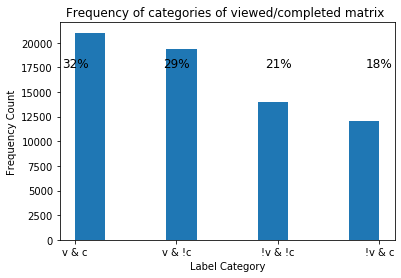

In [24]:
# Frequency of labels in viewed/completed matrix
labels = transformed_offer_df['label']
labels_perc = transformed_offer_df['label'].value_counts()/transformed_offer_df.shape[0]
plt.hist(labels, align = 'mid')
plt.xlabel('Label Category')
plt.xticks([0,1,2,3], labels = ['v & c', 'v & !c', '!v & !c', '!v & c' ]) 
plt.ylabel('Frequency Count')
plt.title('Frequency of categories of viewed/completed matrix ')
#annotate percentages
for i in range(4):
    plt.annotate('{}%'.format(int(round(labels_perc[i]*100))), xy = (i,17500), ha="center", fontsize=12)

plt.show()

From the frequency graph it becomes clear that the frequency of labels is not perfectly balanced. However, the descrepancies are not so immense, that one could talk about a truly imbalanced dataset. Therefore, the dataset does not have to be adjusted to adjust for the differences in frequencies

In the next step it will be investigated how frequently each offer is sent to customers. It would be expected that the frequencies are similar for all offers.

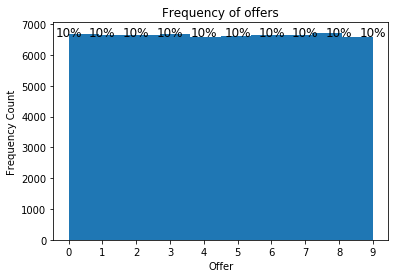

In [23]:
# Frequency of labels in viewed/completed matrix
labels = full_offer_df['offer_id']
labels_perc = full_offer_df['offer_id'].value_counts()/full_offer_df.shape[0]
plt.hist(labels, align = 'mid')
plt.xlabel('Offer')
plt.xticks(np.arange(0, 10), labels = np.arange(0, 10))
plt.ylabel('Frequency Count')
plt.title('Frequency of offers')
#annotate percentages
for i in range(10):
    plt.annotate('{}%'.format(int(round(labels_perc[i]*100))), xy = (i,6600), ha="center", fontsize=12)

plt.show()

As expected, the freuqency counts offer offers sent is well balanced out.

In [137]:
# general info about columns
transformed_offer_df.describe()

,label,cust_age,cust_income,cust_spend_wk_1,cust_spend_wk_2,cust_spend_wk_3,cust_spend_wk_4,offer_channel_web,offer_channel_email,offer_channel_mobile,...,offer_difficulty_10,offer_difficulty_20,offer_duration_3,offer_duration_4,offer_duration_5,offer_duration_7,offer_duration_10,cust_gender_F,cust_gender_M,cust_gender_O
count,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.0,66501.000000,...,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000
mean,1.258026,0.438184,0.393018,0.022116,0.022261,0.029711,0.031854,0.799612,1.0,0.898859,...,0.399377,0.101141,0.099893,0.100104,0.198027,0.400806,0.201170,0.412866,0.573360,0.013774
std,1.089827,0.209583,0.240259,0.046825,0.043923,0.049371,0.059579,0.400294,0.0,0.301518,...,0.489774,0.301518,0.299860,0.300141,0.398516,0.490065,0.400878,0.492353,0.494593,0.116553
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.289157,0.211111,0.000000,0.000748,0.003909,0.004459,1.000000,1.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.445783,0.377778,0.009899,0.011990,0.017771,0.018163,1.000000,1.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2.000000,0.578313,0.555556,0.029131,0.029478,0.040567,0.042117,1.000000,1.0,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 3. Creation of Training & Testing Sets
Having taken a quick look at the transformed_offer_df, the dataframe will now be split into training and testing data. The split training & testing sets will then be uploaded to S3 so they can be used to train machine learning models with Sagemaker

In [3]:
#import train_test_split from scikit-learn
from sklearn.model_selection import train_test_split
# split dataset
X = transformed_offer_df.iloc[:, 1:]
y = transformed_offer_df.iloc[:, 0]
#X = alt_offer_df.iloc[:, 1:]
#y = alt_offer_df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [4]:
# store Training & testing data as csv in format reuqired by S3
#define data_dir where to store
data_dir = 'data/'
#merge dataFrames and drop any incomplete rows 
train_y_x = pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)], axis=1)
train_y_x = train_y_x.dropna()
test_y_x = pd.concat([pd.DataFrame(y_test), pd.DataFrame(X_test)], axis=1)
test_y_x = test_y_x.dropna()
# save to csv
train_y_x.to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
test_y_x.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)



Upload training set to S3

In [5]:
import sagemaker
#get sagemaker session, role and bucket
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

# path to train.csv file
path_train = 'data/train.csv'
# path to test.csv file
path_test = 'data/test.csv'

# set prefix, a descriptive name for a directory  
prefix = 'Starbucks-Capstone-Project'

# upload the training data to S3
train_location = sagemaker_session.upload_data(path_train, bucket = bucket, key_prefix = prefix)
test_location = sagemaker_session.upload_data(path_test, bucket = bucket, key_prefix = prefix)

# 4. Benchmark Model
With the transformed dataset available, the data can now be used to train a model. The first, step is to create a simple Benchmark Model against which the performance of the actual ML model can be judged. For this, a simple guessing model will be used. The model will assign a category at random based on the probabilities of the categories determined in the Data Exploration section

In [141]:
#create a numpy array of the size of the test dataset with randomly selected labels
bench_preds = []
for i in range(y_test.shape[0]):
    #Choose a random number between 0 and 3 with the p
    rand = np.random.choice(np.arange(0, 4), p=[0.32, 0.29, 0.21, 0.18])
    #append the number to the numpy array
    bench_preds.append(int(rand))
bench_preds = np.array(bench_preds)


In [142]:
print(len(bench_preds))

19951


In [143]:
from sklearn.metrics import accuracy_score, classification_report

benchmark_acc = accuracy_score(y_test, bench_preds)
benchmark_metrics = classification_report(y_test, bench_preds, digits=3)

print('Benchmark Model Accuracy: {:.3f}%'.format(benchmark_acc))
print(benchmark_metrics)

Benchmark Model Accuracy: 0.269%
              precision    recall  f1-score   support

           0      0.320     0.323     0.322      6240
           1      0.299     0.293     0.296      5837
           2      0.219     0.229     0.224      4181
           3      0.192     0.185     0.189      3693

    accuracy                          0.269     19951
   macro avg      0.258     0.258     0.258     19951
weighted avg      0.269     0.269     0.269     19951



The accuracy of the Benchmark Model is 27%.

# 5. Machine Learning Models
In the following section three different Machine Learning Models will be trained on the dataset and evaluated against the benchmark model. The Models are a Linear Learner, an XGB Boost classifier, and a Neural Network. The model that performs best, will be used to complete the sample recommendation function.

## 5.1 Linear Learner
The first model will be the Sagemaker built-in Linear Learner.

In [194]:
# define Linear Learner
from sagemaker import LinearLearner
output_path = 's3://{}/{}'.format(bucket, prefix)

ll_estimator = LinearLearner(role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.c4.xlarge',
                          predictor_type='multiclass_classifier',
                          num_classes = 4,
                          output_path=output_path,
                          sagemaker_session=sagemaker_session,
                          epochs=15)


In [195]:
#transform training data to RecordSet for linear learner
train_data = pd.read_csv(train_location, header=None)
train_data = train_data.dropna()

train_data_np_x = train_data.iloc[:,1:].to_numpy().astype('float32')
train_data_np_y = train_data.iloc[:,0].to_numpy().astype('float32')
ll_training_data = ll_estimator.record_set(train_data_np_x, labels=train_data_np_y)

# fit benchmark estimator on the training data
ll_estimator.fit(ll_training_data)

2020-06-24 10:27:26 Starting - Starting the training job...
2020-06-24 10:27:28 Starting - Launching requested ML instances......
2020-06-24 10:28:30 Starting - Preparing the instances for training......
2020-06-24 10:29:46 Downloading - Downloading input data...
2020-06-24 10:30:25 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/24/2020 10:30:28 INFO 139844788803392] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_

[2020-06-24 10:30:35.043] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 1491, "num_examples": 43, "num_bytes": 7391012}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9782779933384487, "sum": 0.9782779933384487, "min": 0.9782779933384487}}, "EndTime": 1592994635.043901, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1592994635.043798}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.966535664876302, "sum": 0.966535664876302, "min": 0.966535664876302}}, "EndTime": 1592994635.043999, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1592994635.043979}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9585056472051712, "sum": 0.9585056472051712, "min": 0.958505647


2020-06-24 10:30:51 Uploading - Uploading generated training model[2020-06-24 10:30:46.978] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 25, "duration": 1479, "num_examples": 43, "num_bytes": 7391012}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9758900131952195, "sum": 0.9758900131952195, "min": 0.9758900131952195}}, "EndTime": 1592994646.978442, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1592994646.978362}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9622591916038876, "sum": 0.9622591916038876, "min": 0.9622591916038876}}, "EndTime": 1592994646.978527, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1592994646.978512}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1,


2020-06-24 10:30:58 Completed - Training job completed
Training seconds: 72
Billable seconds: 72


The trained estimator will now be deployed and then the test data will be passed to the model to evaluate the benchmark's performance.

In [196]:
#deploy the benchmark estimator
predictor = ll_estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!

In [197]:
#Generate Predicted label using the deployed endpoint
#Make sure test data is in right format
test_y_np = y_test.to_numpy().astype('float32')
test_x_np = X_test.to_numpy().astype('float32')

test_y_preds = []
for i in test_x_np:
    result = predictor.predict(i)
    test_y_preds += [x.label['predicted_label'].float32_tensor.values[0] for x in result]
test_y_preds = np.array(test_y_preds).astype(int)

In [198]:
#compare predicted labels with acutal labels and calculate evaluation metrics
#import evaluation metrics accuracy, recall, precision and F-Score
from sklearn.metrics import accuracy_score, classification_report

ll_acc = accuracy_score(y_test, test_y_preds)
ll_metrics = classification_report(y_test, test_y_preds, digits=3)

print('Linear Learner Model Accuracy: {:.3f}%'.format(ll_acc))
print(ll_metrics)

Linear Learner Model Accuracy: 0.594%
              precision    recall  f1-score   support

           0      0.618     0.682     0.648      6240
           1      0.659     0.646     0.652      5837
           2      0.539     0.600     0.568      4181
           3      0.488     0.355     0.411      3693

    accuracy                          0.594     19951
   macro avg      0.576     0.571     0.570     19951
weighted avg      0.589     0.594     0.589     19951



In [199]:
# delete endpoint
predictor.delete_endpoint()

It can be seen that the Linear Learner achieves an accuracy of 59% - 32% points better than the Benchmark Model

## 5.2 XGB Boost
The secon model to be trained an tested is an XGB Boost model. This will be done using the Sagemaker Built-in algorithm.

In [6]:
#get container name
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

#create hyperparameters and other input data necessary
hyperparameters = {"max_depth":"7",
                   "eta":"0.2",
                   "gamma":"4",
                   "min_child_weight":"6",
                   "objective":"multi:softmax",
                   "num_class": "4",
                   "subsample":"0.8",
                   "silent":"0",
                   "early_stopping_rounds" : "10",
                   "num_round":"500"}

output_path = 's3://{}/{}/output/xgb'.format(bucket, prefix)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


In [7]:
#create XGB estimator and train estimator
xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    hyperparameters=hyperparameters,
                                    train_instance_count=1,
                                    train_instance_type= 'ml.m5.2xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sagemaker_session
                                   )


s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
xgb.fit({'train': s3_input_train})

2020-06-24 15:24:03 Starting - Starting the training job...
2020-06-24 15:24:05 Starting - Launching requested ML instances......
2020-06-24 15:25:08 Starting - Preparing the instances for training...
2020-06-24 15:25:57 Downloading - Downloading input data
2020-06-24 15:25:57 Training - Downloading the training image...
2020-06-24 15:26:12 Training - Training image download completed. Training in progress.Arguments: train
[2020-06-24:15:26:13:INFO] Running standalone xgboost training.
[2020-06-24:15:26:13:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-06-24:15:26:13:INFO] File size need to be processed in the node: 7.01mb. Available memory size in the node: 23571.84mb
[2020-06-24:15:26:13:INFO] Determined delimiter of CSV input is ','
[15:26:13] S3DistributionType set as FullyReplicated
[15:26:13] 46550x31 matrix with 1443050 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[15:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[15:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 32 pruned nodes, max_depth=7
[176]#011train-merror:0.301826
[15:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 102 pruned nodes, max_depth=7
[15:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 70 pruned nodes, max_depth=7
[15:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[15:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 66 pruned nodes, max_depth=0
[177]#011train-merror:0.301439
[15:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 118 pruned nodes, max_depth=0
[15:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 84 pruned nodes, max_depth=5
[15:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 94 pruned nodes, max_depth=0
[15:26:31] src/tree/updater_prune.cc

[15:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[283]#011train-merror:0.289903
[15:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 86 pruned nodes, max_depth=7
[15:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 78 pruned nodes, max_depth=6
[15:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 70 pruned nodes, max_depth=7
[15:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 108 pruned nodes, max_depth=5
[284]#011train-merror:0.28971
[15:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 84 pruned nodes, max_depth=0
[15:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 94 pruned nodes, max_depth=0
[15:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 74 pruned nodes, max_depth=0
[15:26:41] src/tree/updater_prune.cc:7


2020-06-24 15:27:03 Uploading - Uploading generated training model[15:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 86 pruned nodes, max_depth=0
[15:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 110 pruned nodes, max_depth=0
[15:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 76 pruned nodes, max_depth=0
[391]#011train-merror:0.281353
[15:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 78 pruned nodes, max_depth=0
[15:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 50 pruned nodes, max_depth=7
[15:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 84 pruned nodes, max_depth=0
[15:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[392]#011train-merror:0.281224
[15:26:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 82

[15:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 110 pruned nodes, max_depth=5
[15:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 92 pruned nodes, max_depth=7
[15:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 102 pruned nodes, max_depth=0
[477]#011train-merror:0.276756
[15:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 90 pruned nodes, max_depth=6
[15:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 72 pruned nodes, max_depth=7
[15:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 74 pruned nodes, max_depth=5
[15:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 98 pruned nodes, max_depth=0
[478]#011train-merror:0.276627
[15:26:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 80 pruned nodes, max_depth=0
[15:26:59] src/tree/updater_prune.c

[15:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 134 pruned nodes, max_depth=0
[15:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 86 pruned nodes, max_depth=6
[15:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 54 pruned nodes, max_depth=6
[15:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 76 pruned nodes, max_depth=0
[499]#011train-merror:0.275102

2020-06-24 15:27:10 Completed - Training job completed
Training seconds: 92
Billable seconds: 92


Deploy and test the XGB Boost model

In [8]:
#deploy the batch transformer endpoint
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------!

In [9]:
#Ensure Test data is in right format
test_y_np = y_test.to_numpy().astype('float32')
test_x_np = X_test.to_numpy().astype('float32')

In [10]:
#Generate Predicted label using the deployed endpoint
from sagemaker.predictor import csv_serializer
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

test_y_preds = []
for i in test_x_np:
    result = predictor.predict(i)
    result = float(result.decode('utf-8'))
    test_y_preds =  np.append(test_y_preds, result)

In [11]:
# change type of test_y_preds array to int
test_y_preds = np.array(test_y_preds).astype(int)

In [14]:
#compare predicted labels with acutal labels and calculate evaluation metrics
xgb_acc = accuracy_score(y_test, test_y_preds)
xgb_metrics = classification_report(y_test, test_y_preds, digits=3)

print('XGB Model Accuracy: {:.3f}%'.format(xgb_acc))
print(xgb_metrics)

XGB Model Accuracy: 0.635%
              precision    recall  f1-score   support

           0      0.612     0.777     0.684      6240
           1      0.701     0.712     0.706      5837
           2      0.652     0.538     0.589      4181
           3      0.536     0.385     0.448      3693

    accuracy                          0.635     19951
   macro avg      0.625     0.603     0.607     19951
weighted avg      0.632     0.635     0.627     19951



In [153]:
# delete endpoint
predictor.delete_endpoint()

The XGB model performs a bit better than the Benchmark Model with an accuracy of 63.6% - 4% better than the linear learner and 36% points better than the Benchmark Model.

## 5.3 Pytorch Neural Network
The second model to be explored will be a neural network. The network will be created with the help of pytorch and therefore requires some helper files. The files model.py, train.py are stored in the source_pytorch folder of the main directory.

In [200]:
from sagemaker.pytorch import PyTorch

nn_estimator = PyTorch(entry_point="train.py",
                       source_dir="source_pytorch",
                       role=role,
                       framework_version='0.4.0',
                       train_instance_count=1,
                       train_instance_type='ml.p2.xlarge',
                       hyperparameters={
                           'epochs': 20,
                           'learningrate':0.001
                       })

In [201]:
nn_estimator.fit({'train': train_location})

2020-06-24 10:45:22 Starting - Starting the training job...
2020-06-24 10:45:24 Starting - Launching requested ML instances......
2020-06-24 10:46:25 Starting - Preparing the instances for training......
2020-06-24 10:47:29 Downloading - Downloading input data...
2020-06-24 10:48:05 Training - Downloading the training image...
2020-06-24 10:48:34 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-24 10:48:35,550 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-24 10:48:35,575 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-24 10:48:35,578 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-24 10:48:35,803 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-06-24 10:48:35,804 sagemake


2020-06-24 10:49:27 Completed - Training job completed
Training seconds: 118
Billable seconds: 118


Having a trained neural network, the model will now be deployed and tested.

In [202]:
predictor = nn_estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------!

In [203]:
y_output = predictor.predict(test_x_np)


In [158]:
pip install torch

     |███████████████████████▉        | 560.3 MB 75.4 MB/s eta 0:00:03     |█████████▏                      | 215.1 MB 2.6 MB/s eta 0:03:25     |███████████▊                    | 276.1 MB 55.3 MB/s eta 0:00:09     |██████████████                  | 330.9 MB 41.0 MB/s eta 0:00:11     |██████████████▏                 | 333.2 MB 41.0 MB/s eta 0:00:11

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [204]:
import torch

#Transform output to labels using softmax
y_pred_softmax = torch.log_softmax(torch.from_numpy(y_output.astype('float32')).float(), dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
y_preds = y_pred_tags.numpy().squeeze()
print(y_preds)

[0 1 0 ... 0 0 0]


In [205]:
#compare predicted labels with acutal labels and calculate evaluation metrics
#import evaluation metrics accuracy, recall, precision and F-Score
nn_acc = accuracy_score(y_test, y_preds)
nn_metrics = classification_report(y_test, y_preds, digits=3)

print('Neural Network Model Accuracy: {:.3f}%'.format(nn_acc))
print(nn_metrics)

Neural Network Model Accuracy: 0.610%
              precision    recall  f1-score   support

           0      0.583     0.792     0.671      6240
           1      0.687     0.661     0.674      5837
           2      0.629     0.503     0.559      4181
           3      0.503     0.342     0.407      3693

    accuracy                          0.610     19951
   macro avg      0.600     0.574     0.578     19951
weighted avg      0.608     0.610     0.600     19951



In [206]:
# delete endpoint
predictor.delete_endpoint()

The neural network shows an accuracy of 61% - 2.5% points worse than the XGB, 2% points better than the Linear Learner and 34% points better than the Benchmark model.

# Sample Recommendation Function
Now that we have tested several different models, it has become evident that the ... model performs best, with an accuracy of ...
Therefore this model will be used in a sample recommendation function. This recommendation function is only a suggestion and mainly serves to show how the model developed above can help in improving the quality of offers sent to customers.

The goal of the recommendation function is to take as input the id of a customer (the customer has to be a part of the clean_profile dataset for the purpose of this exercise) and receive a suggestion of the optimal offer to sent to this customer. This is based on a ranking of the offers which will be explained in more detail later.

The first step is to create a function that creates an input dataframe that can be used on the model endpoint. For this the customer id will be provided and a dataframe will be returned that consists of 10 entries - one per possible offer. 

In [37]:
def get_input_data(cust_id, profile_extended_df, portfolio, scaler, transformed_offer_df):
    ''' Function to create a dataframe with 10 entries that can be used as input for the model. Each row of
    the new dataframe encompasses the customer information, as well as the information of 1 of the 10 offers
    Parameters:
                    cust_id - The unique ID of the customer
                    profile_extended_df - pandas.DataFrame that holds infromation on the weekly transaction 
                        volumes of customers, in addition to the information already known from the profile dataframe
                    scaler - MinMaxScaler object fitted on the entire dataset
                    transformed_offer_df - pd.DataFrame holding the final data for training & testing the models
    Output:
                    cust_recomm_df - pd.DataFrame object that holds the information that will be passed to the model
                        about the customer and the offer
    '''
    #create output dataframe
    column_names = transformed_offer_df.columns
    cust_recomm_df = pd.DataFrame(columns = column_names)
    cust_recomm_df = cust_recomm_df.iloc[:,1:]
    
    #get the customer information from the extended_profile_df
    cust = profile_extended_df.loc[profile_extended_df['id'] == cust_id]
    
    #create dataframe with 10 entries - one for each unqiue offer
    for index, row in portfolio.iterrows():
        entry = {}
        #fill cust_age column
        entry['cust_age'] = cust['age'].squeeze()
        #fill cust_income
        entry['cust_income'] = cust['income'].squeeze()
        #fill cust_spend columns
        entry['cust_spend_wk_1'] = cust['spend_wk_1'].squeeze()
        entry['cust_spend_wk_2'] = cust['spend_wk_2'].squeeze()
        entry['cust_spend_wk_3'] = cust['spend_wk_3'].squeeze()
        entry['cust_spend_wk_4'] = cust['spend_wk_4'].squeeze()
        #fill offer channels
        entry['offer_channel_web'] = row['channel_web']
        entry['offer_channel_email'] = row['channel_email']
        entry['offer_channel_mobile'] = row['channel_mobile']
        entry['offer_channel_social'] = row['channel_social']
        #fill offer type
        if row['offer_type'] == 'bogo':
            entry['offer_type_bogo'] = 1
            entry['offer_type_discount'] = 0
            entry['offer_type_informational'] = 0
        elif row['offer_type'] == 'discount':
            entry['offer_type_bogo'] = 0
            entry['offer_type_discount'] = 1
            entry['offer_type_informational'] = 0
        else:
            entry['offer_type_bogo'] = 0
            entry['offer_type_discount'] = 0
            entry['offer_type_informational'] = 1
        #fill reward
        if row['reward'] == 0:
            entry['offer_reward_0'] = 1
            entry['offer_reward_2'] = 0
            entry['offer_reward_3'] = 0
            entry['offer_reward_5'] = 0
            entry['offer_reward_10'] = 0
        elif row['reward'] == 2:
            entry['offer_reward_0'] = 0
            entry['offer_reward_2'] = 1
            entry['offer_reward_3'] = 0
            entry['offer_reward_5'] = 0
            entry['offer_reward_10'] = 0
        elif row['reward'] == 2:
            entry['offer_reward_0'] = 0
            entry['offer_reward_2'] = 0
            entry['offer_reward_3'] = 1
            entry['offer_reward_5'] = 0
            entry['offer_reward_10'] = 0
        elif row['reward'] == 5:
            entry['offer_reward_0'] = 0
            entry['offer_reward_2'] = 0
            entry['offer_reward_3'] = 0
            entry['offer_reward_5'] = 1
            entry['offer_reward_10'] = 0
        else:
            entry['offer_reward_0'] = 0
            entry['offer_reward_2'] = 0
            entry['offer_reward_3'] = 0
            entry['offer_reward_5'] = 0
            entry['offer_reward_10'] = 1
        #fill difficulty
        if row['difficulty'] == 0:
            entry['offer_difficulty_0'] = 1
            entry['offer_difficulty_5'] = 0
            entry['offer_difficulty_7'] = 0
            entry['offer_difficulty_10'] = 0
            entry['offer_difficulty_20'] = 0
        elif row['difficulty'] == 5:
            entry['offer_difficulty_0'] = 0
            entry['offer_difficulty_5'] = 1
            entry['offer_difficulty_7'] = 0
            entry['offer_difficulty_10'] = 0
            entry['offer_difficulty_20'] = 0
        elif row['difficulty'] == 7:
            entry['offer_difficulty_0'] = 0
            entry['offer_difficulty_5'] = 0
            entry['offer_difficulty_7'] = 1
            entry['offer_difficulty_10'] = 0
            entry['offer_difficulty_20'] = 0
        elif row['difficulty'] == 10:
            entry['offer_difficulty_0'] = 0
            entry['offer_difficulty_5'] = 0
            entry['offer_difficulty_7'] = 0
            entry['offer_difficulty_10'] = 1
            entry['offer_difficulty_20'] = 0
        else:
            entry['offer_difficulty_0'] = 0
            entry['offer_difficulty_5'] = 0
            entry['offer_difficulty_7'] = 0
            entry['offer_difficulty_10'] = 0
            entry['offer_difficulty_20'] = 1
        #fill duration
        if row['duration'] == 3:
            entry['offer_duration_3'] = 1
            entry['offer_duration_4'] = 0
            entry['offer_duration_5'] = 0
            entry['offer_duration_7'] = 0
            entry['offer_duration_10'] = 0
        elif row['duration'] == 4:
            entry['offer_duration_3'] = 0
            entry['offer_duration_4'] = 1
            entry['offer_duration_5'] = 0
            entry['offer_duration_7'] = 0
            entry['offer_duration_10'] = 0
        elif row['duration'] == 5:
            entry['offer_duration_3'] = 0
            entry['offer_duration_4'] = 0
            entry['offer_duration_5'] = 1
            entry['offer_duration_7'] = 0
            entry['offer_duration_10'] = 0
        elif row['duration'] == 7:
            entry['offer_duration_3'] = 0
            entry['offer_duration_4'] = 0
            entry['offer_duration_5'] = 0
            entry['offer_duration_7'] = 1
            entry['offer_duration_10'] = 0
        else:
            entry['offer_duration_3'] = 0
            entry['offer_duration_4'] = 0
            entry['offer_duration_5'] = 0
            entry['offer_duration_7'] = 0
            entry['offer_duration_10'] = 1
        #fill customer gender
        if cust['gender'].squeeze() == 'F':
            entry['cust_gender_F'] = 1
            entry['cust_gender_M'] = 0
            entry['cust_gender_O'] = 0
        elif cust['gender'].squeeze() == 'M':
            entry['cust_gender_F'] = 0
            entry['cust_gender_M'] = 1
            entry['cust_gender_O'] = 0
        else:
            entry['cust_gender_F'] = 0
            entry['cust_gender_M'] = 0
            entry['cust_gender_O'] = 1
        
        #append entry to dataframe
        cust_recomm_df = cust_recomm_df.append(entry, ignore_index=True)
    
    #scale all non binary variables with the scaler object used earlier
    #specify columns that have to be scaled by MinMaxScaler
    column_names_scale = ['cust_age','cust_income', 'cust_spend_wk_1', 'cust_spend_wk_2', 'cust_spend_wk_3', 'cust_spend_wk_4']
    #transform all non-categorical columns of the dataframe
    cust_recomm_df[column_names_scale] = scaler.transform(cust_recomm_df[column_names_scale].astype(np.float64))
    
    return cust_recomm_df

In [119]:
#alternative function for use on the alternative dataset
def get_input_data_2(cust_id, profile_extended_df, portfolio, scaler, transformed_offer_df):
    ''' Function to create a dataframe with 10 entries that can be used as input for the model. Each row of
    the new dataframe encompasses the customer information, as well as the information of 1 of the 10 offers
    Parameters:
                    cust_id - The unique ID of the customer
                    profile_extended_df - pandas.DataFrame that holds infromation on the weekly transaction 
                        volumes of customers, in addition to the information already known from the profile dataframe
                    scaler - MinMaxScaler object fitted on the entire dataset
                    transformed_offer_df - pd.DataFrame holding the final data for training & testing the models
    Output:
                    cust_recomm_df - pd.DataFrame object that holds the information that will be passed to the model
                        about the customer and the offer
    '''
    #create output dataframe
    column_names = transformed_offer_df.columns
    cust_recomm_df = pd.DataFrame(columns = column_names)
    cust_recomm_df = cust_recomm_df.iloc[:,1:]
    
    #get the customer information from the extended_profile_df
    cust = profile_extended_df.loc[profile_extended_df['id'] == cust_id]
    
    #create dataframe with 10 entries - one for each unqiue offer
    for index, row in portfolio.iterrows():
        entry = {}
        #fill cust_age column
        entry['cust_age'] = cust['age'].squeeze()
        #fill cust_income
        entry['cust_income'] = cust['income'].squeeze()
        #fill cust_spend columns
        entry['cust_spend_wk_1'] = cust['spend_wk_1'].squeeze()
        entry['cust_spend_wk_2'] = cust['spend_wk_2'].squeeze()
        entry['cust_spend_wk_3'] = cust['spend_wk_3'].squeeze()
        entry['cust_spend_wk_4'] = cust['spend_wk_4'].squeeze()
        #fill offer duration
        entry['offer_duration'] = row['duration']
        #fill offer type
        if row['offer_type'] == 'bogo':
            entry['offer_type_bogo'] = 1
            entry['offer_type_discount'] = 0
            entry['offer_type_informational'] = 0
        elif row['offer_type'] == 'discount':
            entry['offer_type_bogo'] = 0
            entry['offer_type_discount'] = 1
            entry['offer_type_informational'] = 0
        else:
            entry['offer_type_bogo'] = 0
            entry['offer_type_discount'] = 0
            entry['offer_type_informational'] = 1
        #fill customer gender
        if cust['gender'].squeeze() == 'F':
            entry['cust_gender_F'] = 1
            entry['cust_gender_M'] = 0
            entry['cust_gender_O'] = 0
        elif cust['gender'].squeeze() == 'M':
            entry['cust_gender_F'] = 0
            entry['cust_gender_M'] = 1
            entry['cust_gender_O'] = 0
        else:
            entry['cust_gender_F'] = 0
            entry['cust_gender_M'] = 0
            entry['cust_gender_O'] = 1
        
        #append entry to dataframe
        cust_recomm_df = cust_recomm_df.append(entry, ignore_index=True)
    
    #scale all non binary variables with the scaler object used earlier
    #specify columns that have to be scaled by MinMaxScaler
    column_names_scale = ['cust_age','cust_income', 'cust_spend_wk_1', 'cust_spend_wk_2', 'cust_spend_wk_3', 
                          'cust_spend_wk_4', 'offer_duration']
    #transform all non-categorical columns of the dataframe
    cust_recomm_df[column_names_scale] = scaler.transform(cust_recomm_df[column_names_scale].astype(np.float64))
    
    return cust_recomm_df

In the second step a function will be defined that calls the model endpoint to get the predictions from the just created dataframe and then returns a recommendation

In [207]:
def get_recommendation(cust_id, profile_extended_df, portfolio, scaler, transformed_offer_df):
    ''' Function to create a recommendation of the best offer to sent to a customer based on the customer's id.
    Parameters:
                    cust_id - The unique ID of the customer
                    profile_extended_df - pandas.DataFrame that holds infromation on the weekly transaction 
                        volumes of customers, in addition to the information already known from the profile dataframe
                    scaler - MinMaxScaler object fitted on the entire dataset
                    transformed_offer_df - pd.DataFrame holding the final data for training & testing the models
    Output:
                    recomm - offer-id of the best possible offer to sent to a customer.
    '''
    #get dataframe to sent to model endpoint
    cust_recomm_df = get_input_data(ident, profile_extended_df, portfolio, scaler, transformed_offer_df)
    #transform to numpy for use 
    cust_recomm_np = cust_recomm_df.to_numpy().astype('float32')
    #get predictions
    #for xgb
    output = []
    for i in cust_recomm_np:
        result = predictor.predict(i)
        result = float(result.decode('utf-8'))
        output = np.append(output, result)
    
    #for nn
    #output = predictor.predict(cust_recomm_np)
    #pred_softmax = torch.log_softmax(torch.from_numpy(output.astype('float32')).float(), dim = 1)
    #_, pred_tags = torch.max(pred_softmax, dim = 1)
    #output = pred_tags.numpy().squeeze()
    
    
    #create portfolio dataframe with added column for expected outcome
    portfolio_recomm = portfolio.copy()
    portfolio_recomm['result'] = np.array(output).astype(int).tolist()
    
    #rerank the dataframe based on the outcome (0-best, 4-worst), then duration(shortest = best), 
    #then difficulty (highest = best)
    portfolio_recomm = portfolio_recomm.sort_values(by =['result', 'duration', 'difficulty'], ascending = (True, True, False))
    
    #return the id of the first item of the dataframe
    recomm = portfolio_recomm.head(1)['id'].squeeze()
    
    return recomm

Example of how the function could be used based on a random id from the clean_profile_id dataframe

In [121]:
#create recommendations for five random people from the clean_profile dataframe
#create list of 5 random numbers in range of clean_profile datafram
cust_ids = []
for i in range(5):
    index = np.random.randint(0, clean_profile.shape[0]+1)
    cust_ids = np.append(cust_ids, profile_extended_df.iloc[index,:]['id'])

#call get_recommendation for each of the 5 customers
for i in range(len(cust_ids)):
    recomm = get_recommendation(cust_ids[i], profile_extended_df, portfolio, scaler, transformed_offer_df)
    print('For customer {}, the best offer is {}'.format(cust_ids[i], recomm))

For customer f726eb45d69845b9b5b8100d074c64f7, the best offer is 5a8bc65990b245e5a138643cd4eb9837
For customer b6ef8b6a987c48d5ac80630932600492, the best offer is 5a8bc65990b245e5a138643cd4eb9837
For customer 625b2edda53f4e5db514565ee8c11e17, the best offer is 5a8bc65990b245e5a138643cd4eb9837
For customer 318e17ecccad4be291978efac19618bb, the best offer is 5a8bc65990b245e5a138643cd4eb9837
For customer 3c1672777a574c51ac6a07df33da9577, the best offer is 5a8bc65990b245e5a138643cd4eb9837


In [ ]:
# delete endpoint
predictor.delete_endpoint()

Based on the prediction function it was seen that the models always choose the same models. Therefore a function will be built that shows the assignment category the model gives to each of the 10 offers.

In [57]:
def get_assignmetn_df(cust_id, profile_extended_df, portfolio, scaler, transformed_offer_df):
    ''' Function to create a recommendation of the best offer to sent to a customer based on the customer's id.
    Parameters:
                    cust_id - The unique ID of the customer
                    profile_extended_df - pandas.DataFrame that holds infromation on the weekly transaction 
                        volumes of customers, in addition to the information already known from the profile dataframe
                    scaler - MinMaxScaler object fitted on the entire dataset
                    transformed_offer_df - pd.DataFrame holding the final data for training & testing the models
    Output:
                    recomm - offer-id of the best possible offer to sent to a customer.
    '''
    #get dataframe to sent to model endpoint
    cust_recomm_df = get_input_data(ident, profile_extended_df, portfolio, scaler, transformed_offer_df)
    #transform to numpy for use 
    cust_recomm_np = cust_recomm_df.to_numpy().astype('float32')
    #get predictions
    #for xgb
    output = []
    for i in cust_recomm_np:
        result = predictor.predict(i)
        result = float(result.decode('utf-8'))
        output = np.append(output, result)
    
    #for nn
    #output = predictor.predict(cust_recomm_np)
    #pred_softmax = torch.log_softmax(torch.from_numpy(output.astype('float32')).float(), dim = 1)
    #_, pred_tags = torch.max(pred_softmax, dim = 1)
    #output = pred_tags.numpy().squeeze()
    
    
    #create portfolio dataframe with added column for expected outcome
    portfolio_recomm = portfolio.copy()
    portfolio_recomm['label'] = np.array(output).astype(int).tolist()
    
    #rerank the dataframe based on the outcome (0-best, 4-worst), then duration(shortest = best), 
    #then difficulty (highest = best)
    portfolio_recomm = portfolio_recomm.sort_values(by =['label', 'duration', 'difficulty'], ascending = (True, True, False))
    #return the dataframe
    return portfolio_recomm

In [58]:
#get the assignemtn dataframe using an example id
ident = 'b6ef8b6a987c48d5ac80630932600492'
df = get_assignmetn_df(ident, profile_extended_df, portfolio, scaler, transformed_offer_df)
df.head(10)

,reward,difficulty,duration,offer_type,id,channel_web,channel_email,channel_mobile,channel_social,label
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,2
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,2
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,2
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,3
